# Data Mining Investigation

**Goal**: What factors are best able to predict the severity of an accident? (Classification)

In [408]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

In [409]:
db = pymysql.connect(host="marmoset04.shoshin.uwaterloo.ca", user="r72huang", passwd="Password@123", db="db356_r72huang")
cur = db.cursor()

In [410]:
queryAgeRanges = """select concat(Person.accidentID, Person.personID) as personID, ag.description as ageRange from Person 
                    left join AgeGroup ag using (ageGroupID);"""
queryCondition = """select accidentID, temperature, humidity, weather, visibility from Accident
                    left join WeatherCondition using (accidentID)"""

# Analyze Age Data

In [411]:
cur.execute(queryAgeRanges)
df = pd.DataFrame(cur.fetchall(), columns=[data[0] for data in cur.description])
df.head()

personID ageRange
0  1000212      0-3
1  1006723      0-3
2  1007532      0-3
3  1011731      0-3
4  1013710      0-3

In [412]:
df.groupby(['ageRange']).size()

ageRange
0-3         1607
13-15       1657
16-20       8390
21-24       7967
25-34      14442
35-44      10964
4-7         1519
45-54      11142
55-64       9251
65-74       5581
75+         4442
8-12        1958
Unknown     1668
dtype: int64

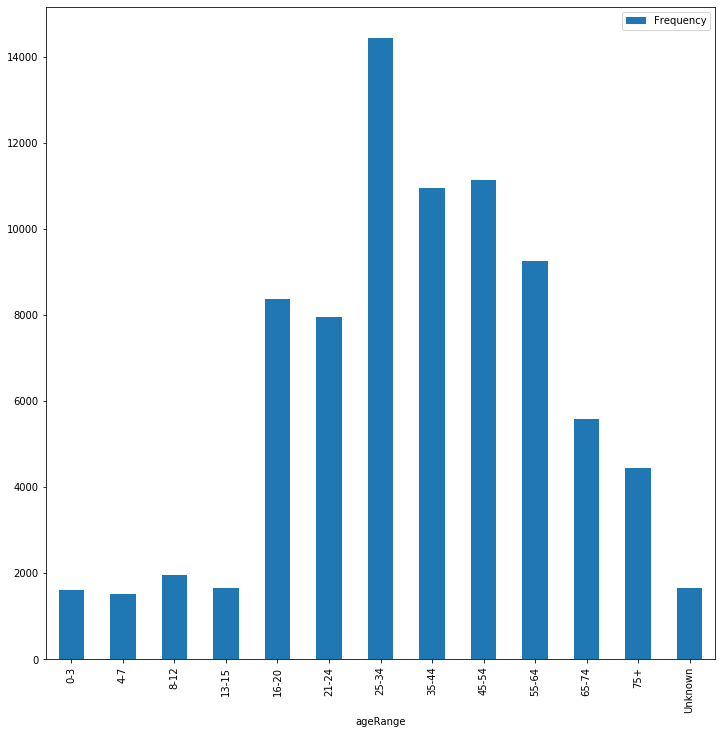

In [413]:
ageFreq = df.groupby(["ageRange"]).size().to_frame("Frequency")
ageFreq = ageFreq.reset_index().reindex([0,6,11,1,2,3,4,5,7,8,9,10,12])
ageFreq.plot(x="ageRange", y="Frequency", kind='bar', figsize=(12, 12))

We see that most of the accidents occur during the same period where the majority of the population joins the workforce (25 - 34). This distribution is proportional to age groups of US drivers but the mean is shifted to left since younger drivers are more likely to have riskier habits when it comes to driving.

# Part 1: Weather Data Clustering attempt

In [414]:
cur.execute(queryCondition)
df = pd.DataFrame(cur.fetchall(), columns=[data[0] for data in cur.description])
df.describe()

accidentID  temperature     humidity   visibility
count  4.216900e+04  9884.000000  9873.000000  9852.000000
mean   9.430822e+05    63.461847    57.837233     9.444194
std    1.031253e+07    12.989752    20.660075     1.915099
min    1.000100e+04     3.000000     4.000000     0.200000
25%    1.703000e+05    57.900000    44.000000    10.000000
50%    3.709470e+05    64.000000    59.000000    10.000000
75%    5.501150e+05    70.000000    73.000000    10.000000
max    1.217191e+09   102.900000   100.000000    30.000000

# Clean Weather Data

Remove NA and Null values

In [415]:
df.isna().sum()

accidentID         0
temperature    32285
humidity       32296
weather        32286
visibility     32317
dtype: int64

In [416]:
df = df.dropna()
df.count()

accidentID     9799
temperature    9799
humidity       9799
weather        9799
visibility     9799
dtype: int64

In [417]:
df[["temperature", "humidity", "visibility"]] = df[["temperature", "humidity", "visibility"]] \
    .fillna(df[["temperature", "humidity", "visibility"]].mean())

# Analyze Weather Data

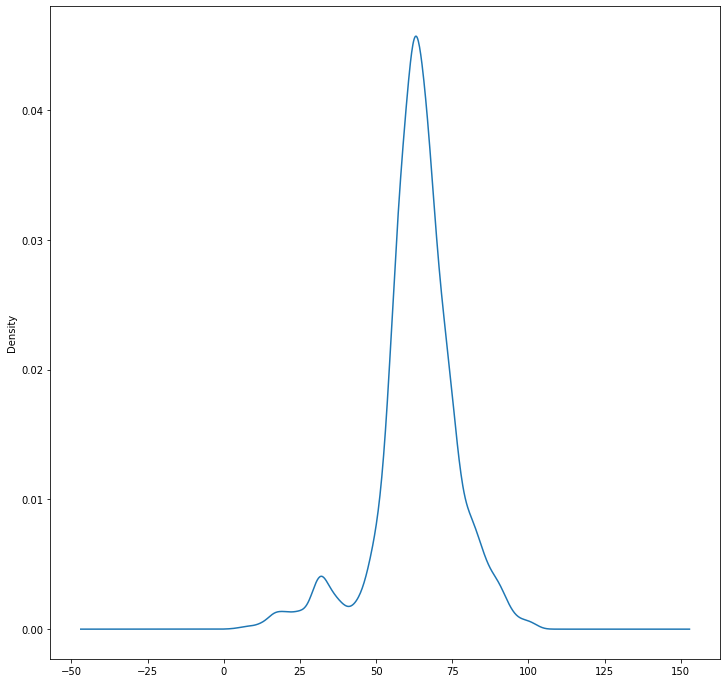

In [418]:
# Distribution of temperature in F during accidents
df["temperature"].plot(kind="kde", figsize=(12,12))

Mean is 63F = 17C. This distribution can be explained by the fact that more people drive during good weather. So, the majority of the accidents occur during 17C even though colder weather maybe risker for the car. Additionally, US in general has warmer weather.

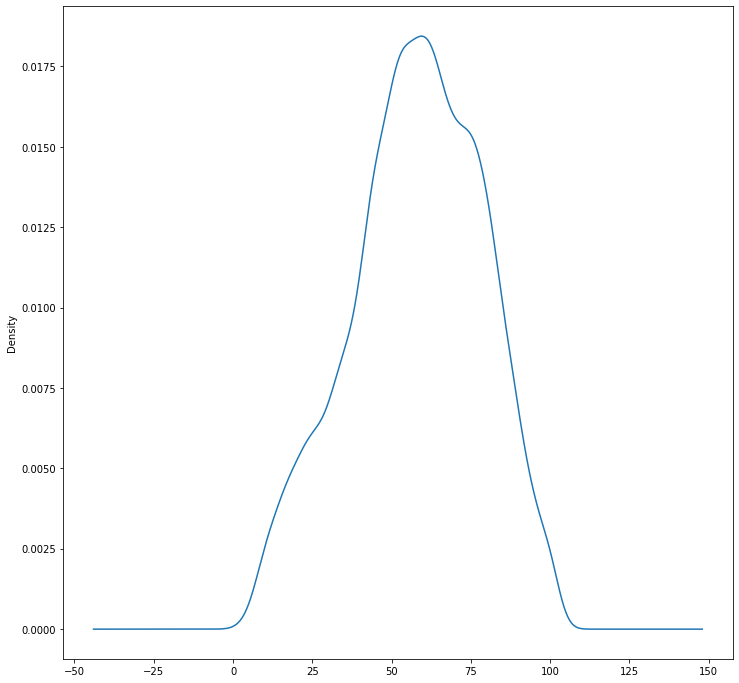

In [419]:
# Distribution of humidity in % during accidents
df["humidity"].plot(kind="kde", figsize=(12, 12))

The average humiditiy is 58%.

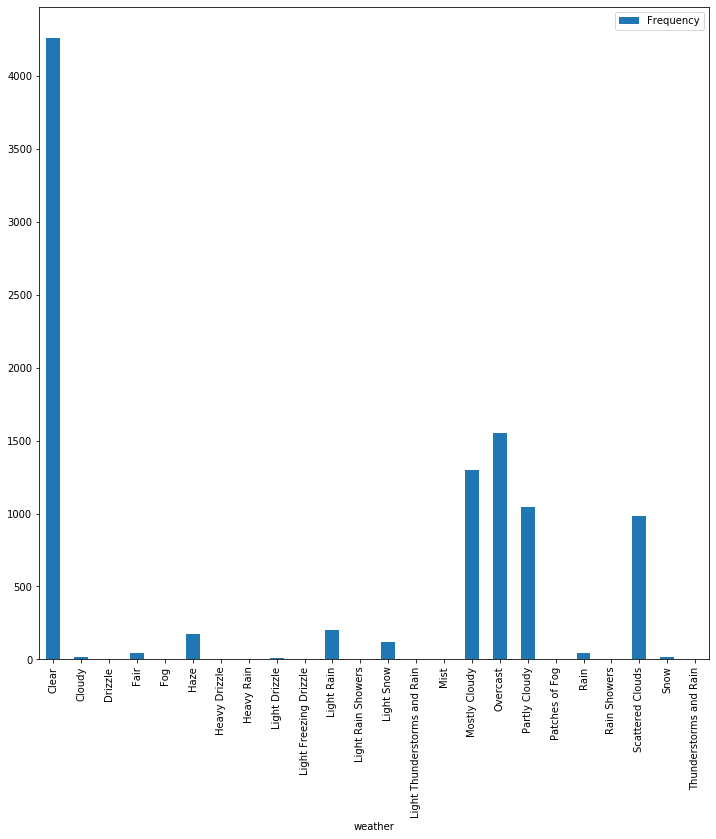

In [420]:
weatherFreq = df.groupby(["weather"]).size().to_frame("Frequency")
weatherFreq.plot(kind='bar', figsize=(12,12))

Interestingly enough, most of the accidents occur during clear weather. Perhaps most individuals prefer driving during clear weather then any other weather, so most accidents occur during that weather. 

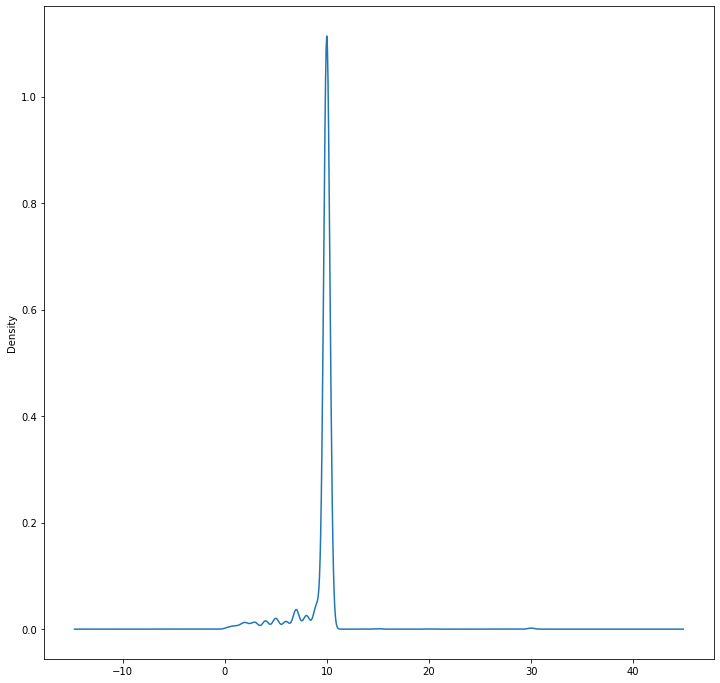

In [422]:
# Distribution of visibility in miles during accident
df["visibility"].plot(kind="kde", figsize=(12, 12))

Most individuals had a visibility of 10 miles before their accident

# Tokenize Strings 

In [423]:
le = LabelEncoder()
df["weather"] = le.fit_transform([weather for weather in df["weather"].values])
df = df.drop("accidentID", 1)

/home/wahab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [424]:
X = scale(df.values)

# Elbow Method

Text(0, 0.5, 'Sum of squared distance')

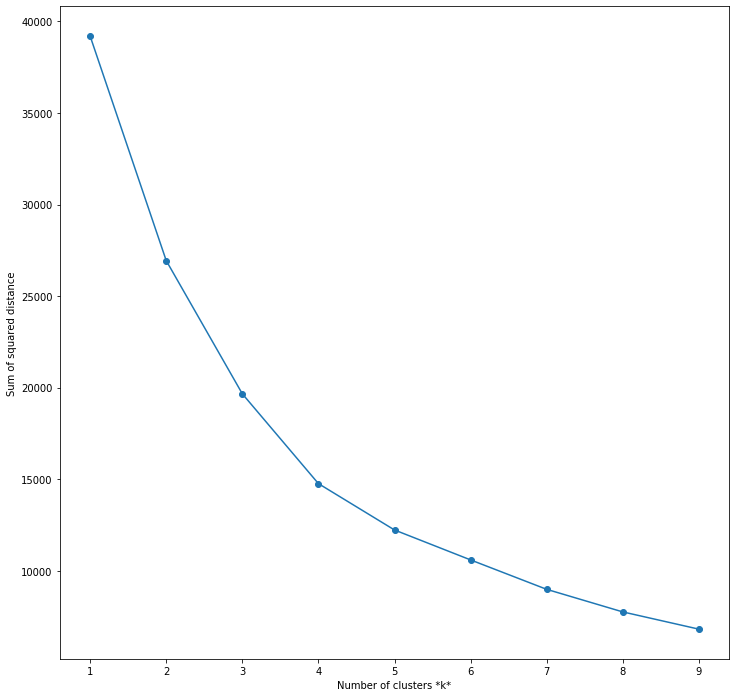

In [396]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 12))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

**No visible elbow => There are no good clusters for weather**

# PART 2: Predict Severity of Crash from Driver Conditions


Check if it is possible to classify severity of crash from the Crash table using driver details from Driver table.
Ex. What are possible / most likely crash severities from distracted driving

In [397]:
queryConditionAndSeverity = """select isDriverDrowsy, isDriverDistracted, ot.description as isDriverDrunk,
            ct.description as crashSeverity from Driver
             left join OptionType ot on optionTypeID=isDriverDrunkID
             left join Accident using (accidentID)
             left join CrashType ct using (crashTypeID)"""

In [398]:
cur.execute(queryConditionAndSeverity)
df = pd.DataFrame(cur.fetchall(), columns=[data[0] for data in cur.description])
df.head()

isDriverDrowsy  isDriverDistracted isDriverDrunk         crashSeverity
0               0                   0           Yes     Two-Vehicle Crash
1               0                   0            No  Single-Vehicle Crash
2               1                   1           Yes  Single-Vehicle Crash
3               0                   0           Yes  Single-Vehicle Crash
4               0                   0           Yes  Single-Vehicle Crash

In [399]:
df.isna().sum()

isDriverDrowsy        0
isDriverDistracted    0
isDriverDrunk         0
crashSeverity         0
dtype: int64

# Analyze Crash Severity

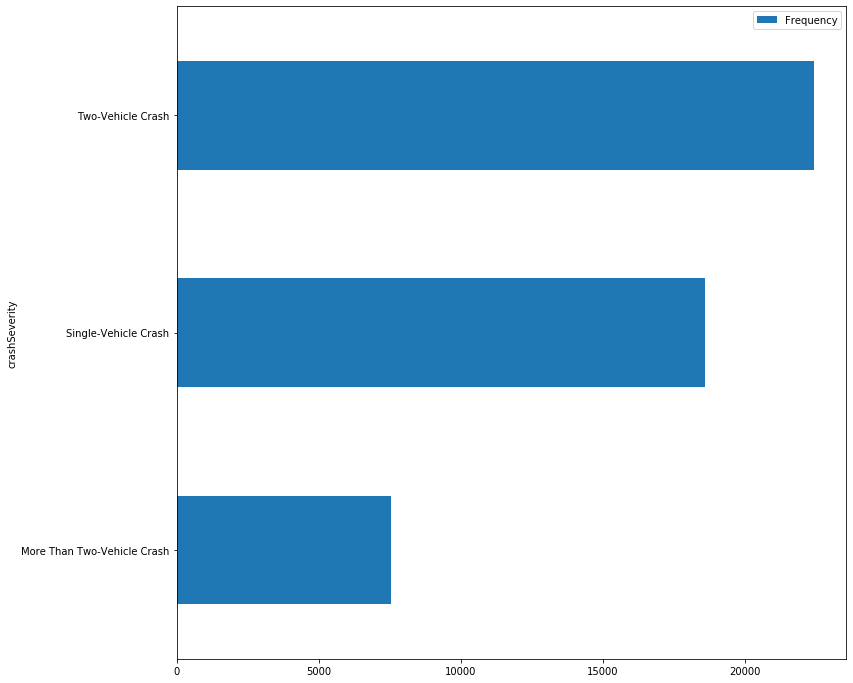

In [400]:
df.groupby(["crashSeverity"]).size().to_frame("Frequency").plot(kind="barh", figsize=(12, 12))

Two vehicle crash is the most likely, followed by single vehicle crash and more than two vehicle crash.

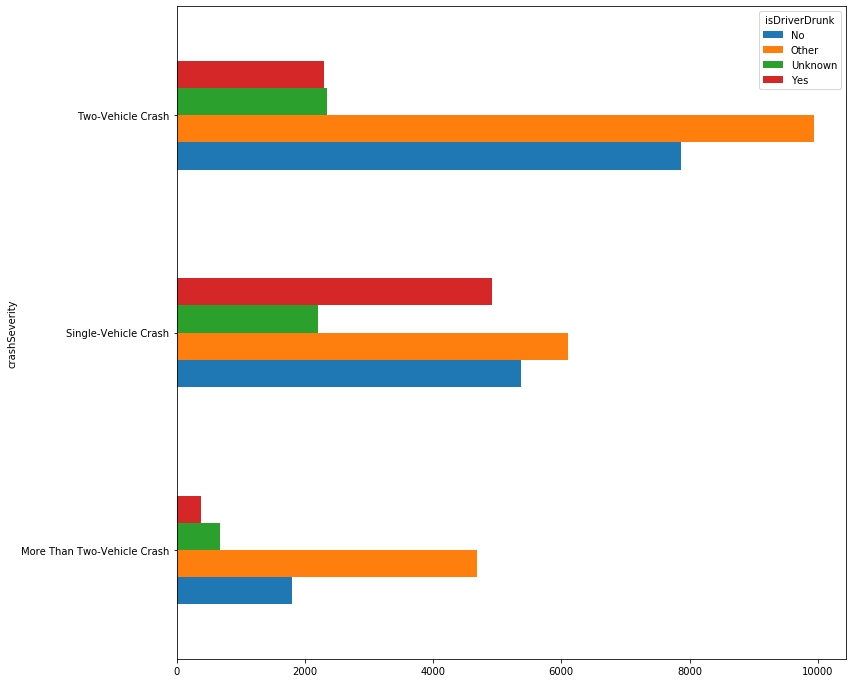

In [401]:
df.groupby(["crashSeverity", "isDriverDrunk"]).size().unstack().plot.barh(figsize=(12, 12))

**Fig 1**

Two Vehicle Crash
- The most common type of accident
- "Other" dominates potentially indicating that drivers may be under other influences

Single Vehicle Crash
- Second most common type of accident
- Again, "Other" dominates potentially indicating that drivers may be under other influences
- This time the number of crashes due to drunk driving is roughly equivalent the number of crashes without drinking. This suggests that drinking and driving is especially dangerous for single vehicle crashes.

More Than Two Vehicle Crash
 - Least common
 - Again, "Other" dominates potentially indicating that drivers may be under other influences

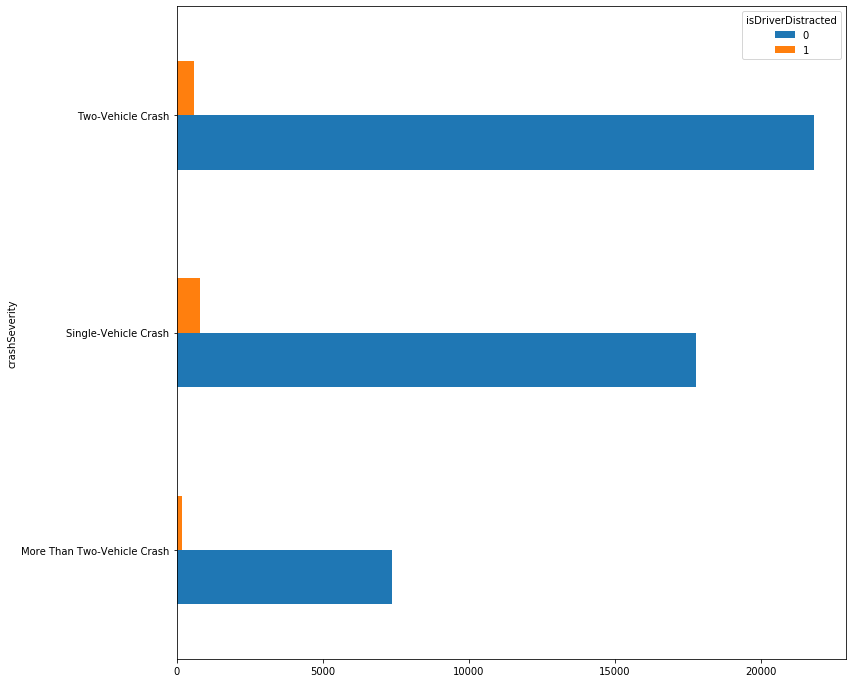

In [402]:
df.groupby(["crashSeverity", "isDriverDistracted"]).size().unstack().plot.barh(figsize=(12, 12))

In the majority of the accidents the driver is not distracted.

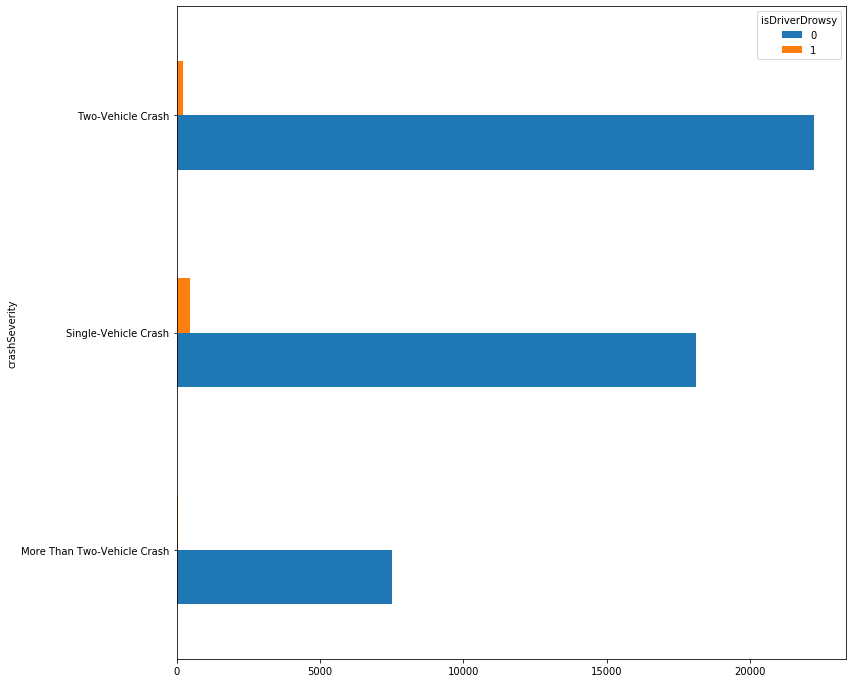

In [403]:
df.groupby(["crashSeverity", "isDriverDrowsy"]).size().unstack().plot.barh(figsize=(12, 12))

In the majority of the accidents the driver is not drowsy.

In [361]:
df.head()

isDriverDrowsy  isDriverDistracted isDriverDrunk         crashSeverity
0               0                   0           Yes     Two-Vehicle Crash
1               0                   0            No  Single-Vehicle Crash
2               1                   1           Yes  Single-Vehicle Crash
3               0                   0           Yes  Single-Vehicle Crash
4               0                   0           Yes  Single-Vehicle Crash

# Tokenize Strings

In [362]:
df_t = df.copy()
le = LabelEncoder()
df_t["isDriverDrunk"] = le.fit_transform([token for token in df_t["isDriverDrunk"].values])
df_t["crashSeverity"] = le.fit_transform([token for token in df_t["crashSeverity"].values])
df_t.head()

isDriverDrowsy  isDriverDistracted  isDriverDrunk  crashSeverity
0               0                   0              3              2
1               0                   0              0              1
2               1                   1              3              1
3               0                   0              3              1
4               0                   0              3              1

# Elbow Method for Cluster Count

Text(0, 0.5, 'Sum of squared distance')

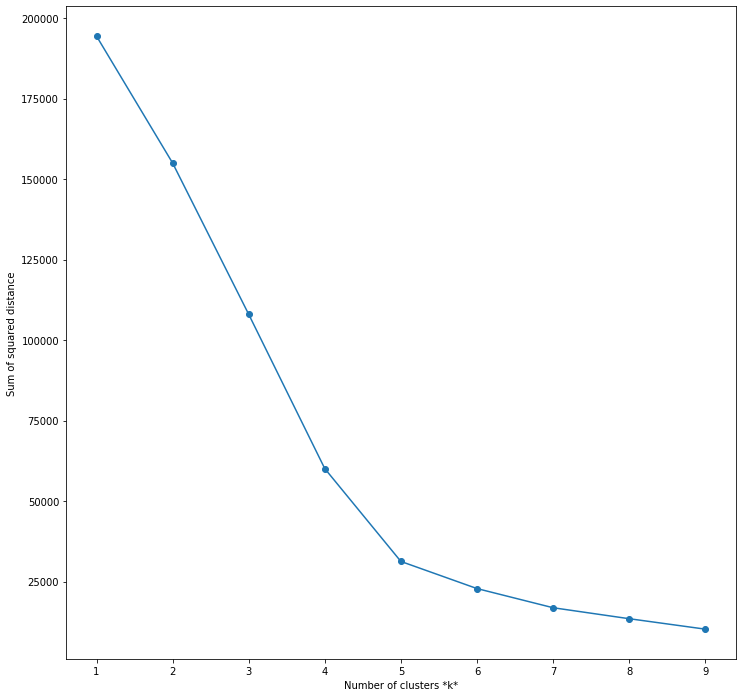

In [404]:
X = scale(df_t.values)
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 12))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Potential elbow at 5, needs further investigation...

# K-Means

In [364]:
km = KMeans(n_clusters=5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Visualize Clustering Using Dimensionality Reduction

In [365]:
centroids, labels = km.cluster_centers_, km.labels_

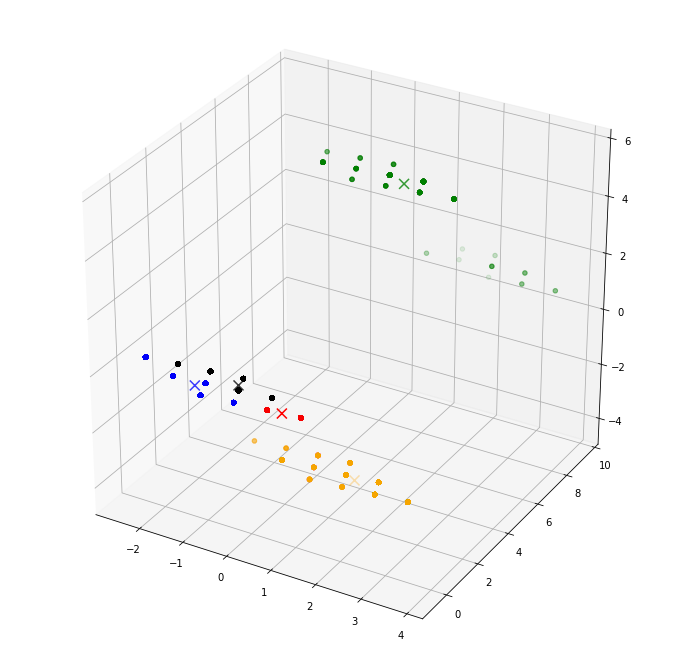

In [366]:
pca_model = PCA(n_components=3)
pca_model.fit(X)
T = pca_model.transform(X)
centroid_pca = pca_model.transform(centroids)
colors = ['blue', 'red', 'green', 'orange', 'black']
features_colors = [ colors[labels[i]] for i in range(len(T)) ]

fig = plt.figure(figsize=(12, 12))
fig = fig.add_subplot(projection='3d')


# plot the PCA components
fig.scatter(T[:, 0], T[:, 1], T[:, 2],
            c=features_colors, marker='o',
            alpha=0.1,
        )

# plot the centroids
fig.scatter(centroid_pca[:, 0], centroid_pca[:, 1], centroid_pca[:, 2],
            marker='x', s=100,
            linewidths=3, c=colors,
        )

# fig.figure

# Labeling Clusters

In [405]:
df["Cluster"] = features_colors
df

isDriverDrowsy  isDriverDistracted isDriverDrunk         crashSeverity  \
0                   0                   0           Yes     Two-Vehicle Crash   
1                   0                   0            No  Single-Vehicle Crash   
2                   1                   1           Yes  Single-Vehicle Crash   
3                   0                   0           Yes  Single-Vehicle Crash   
4                   0                   0           Yes  Single-Vehicle Crash   
...               ...                 ...           ...                   ...   
48609               0                   0         Other     Two-Vehicle Crash   
48610               0                   1            No     Two-Vehicle Crash   
48611               0                   0         Other     Two-Vehicle Crash   
48612               0                   0         Other     Two-Vehicle Crash   
48613               0                   0         Other  Single-Vehicle Crash   

      Cluster  
0        blue  
1       black  
2       green  
3        blue  
4        blue  
...       ...  
48609     red  
48610  orange  
48611     red  
48612     red  
48613   black  

[48614 rows x 5 columns]

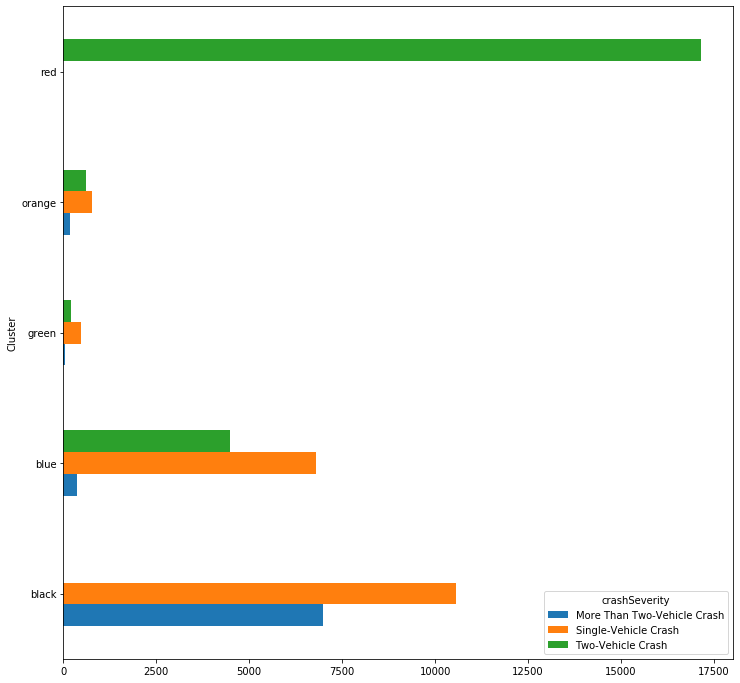

In [406]:
df.groupby(["Cluster", "crashSeverity"]).size().unstack().plot.barh(figsize=(12, 12))

Summary of the result. Explained in more detal below.

# Red Cluster

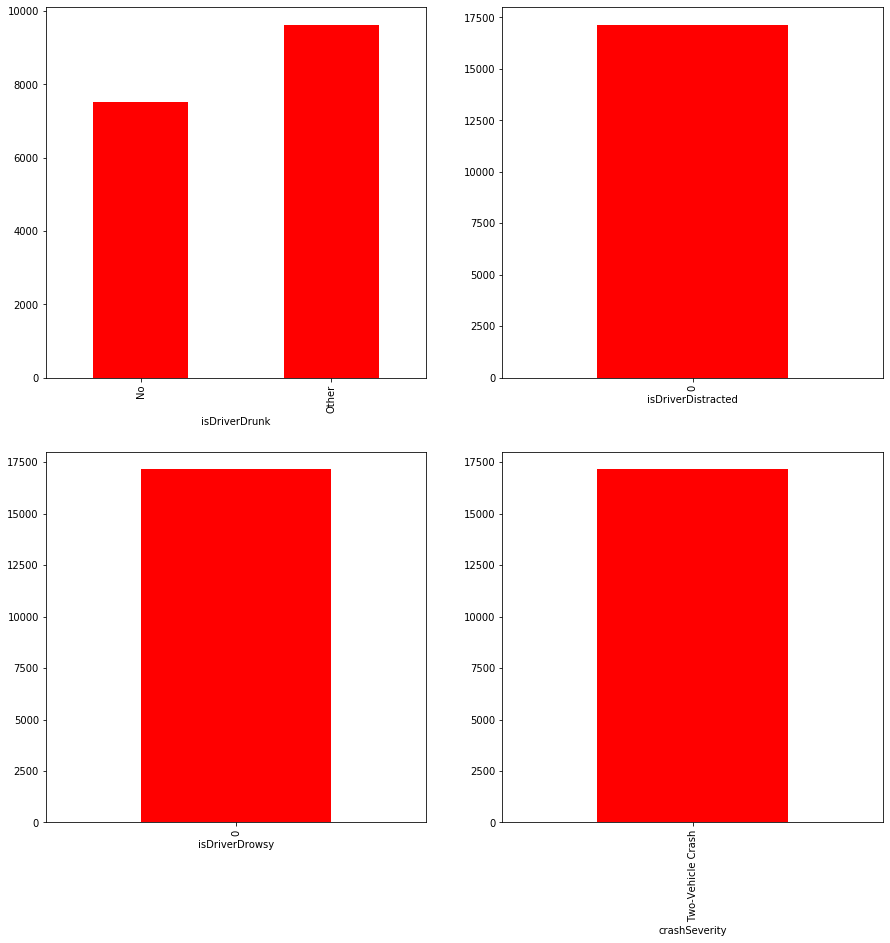

In [373]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

df_red = df.loc[df['Cluster'] == "red"]

df_red.groupby(["isDriverDrunk"]).size().plot(kind="bar", ax=axes[0,0], color="red")
df_red.groupby(["isDriverDistracted"]).size().plot(kind="bar", ax=axes[0,1], color="red")
df_red.groupby(["isDriverDrowsy"]).size().plot(kind="bar", ax=axes[1,0], color="red")
df_red.groupby(["crashSeverity"]).size().plot(kind="bar", ax=axes[1,1], color="red")

# Black Cluster

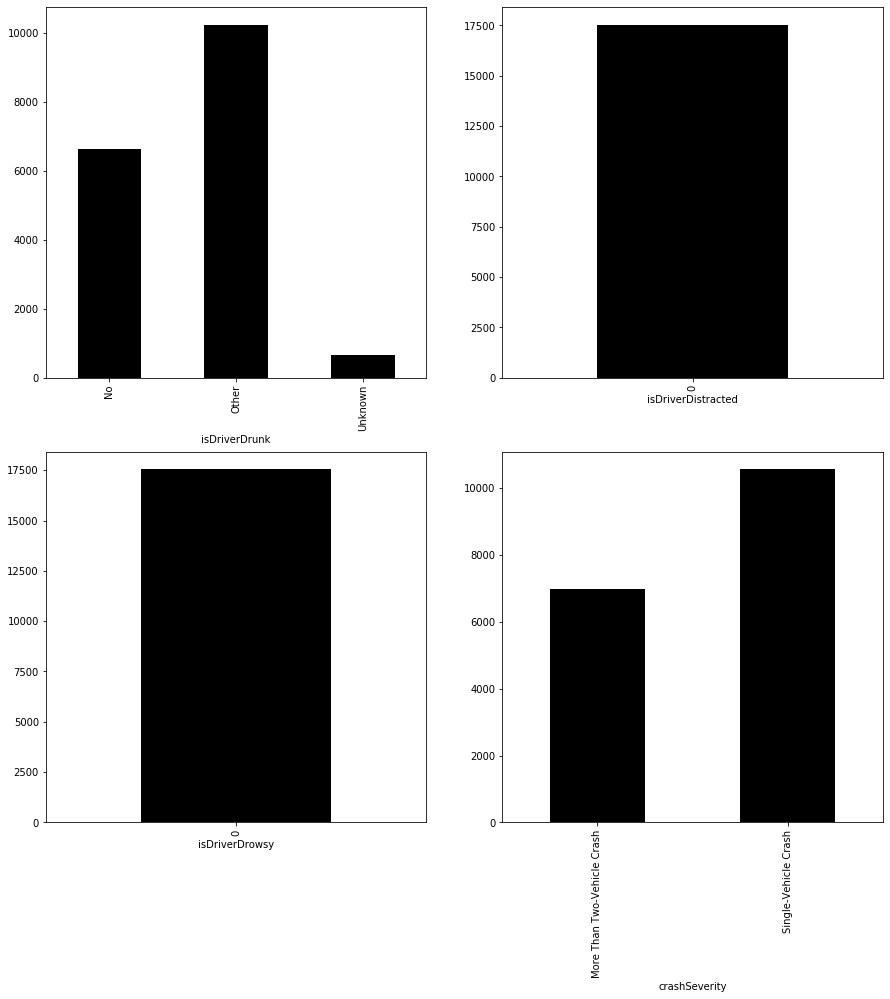

In [372]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

df_black = df.loc[df['Cluster'] == "black"]

df_black.groupby(["isDriverDrunk"]).size().plot(kind="bar", ax=axes[0,0], color="black")
df_black.groupby(["isDriverDistracted"]).size().plot(kind="bar", ax=axes[0,1], color="black")
df_black.groupby(["isDriverDrowsy"]).size().plot(kind="bar", ax=axes[1,0], color="black")
df_black.groupby(["crashSeverity"]).size().plot(kind="bar", ax=axes[1,1], color="black")

That there are abundent number of accident where the driver is either under the influence of some other substance or sober or unknown. Where the outcome is more than "two-vehicle crash" or a "single-vechicle crash". The important observation this time is that a driver which is under the influence of some other substance has a good chance of getting into a single vehicle crash, which could with a pedistrian or with some road marking. Which seems reasonable.

If the driver is under the influence of some "Other" substance OR if the driver is sober AND the driver is not distracted and is not drowsy then a two vehicle crash is highly likely.

Does this make sense?

If the driver is under the influence of some "Other" substance then a two vehicle crash is likely regardless of weather or not the driver is distracted or drowsy.

If the driver is sober and is not drowsy and is not distracted then a two vehicle crash seems unlikely. However, given that the majority of two-vehicle car crashes happen due to a minority of individuals that are under some other influence (Fig 1), it is perfectly plausable that that sober driver fall victim to these individuals in the other car.

# Blue Cluster

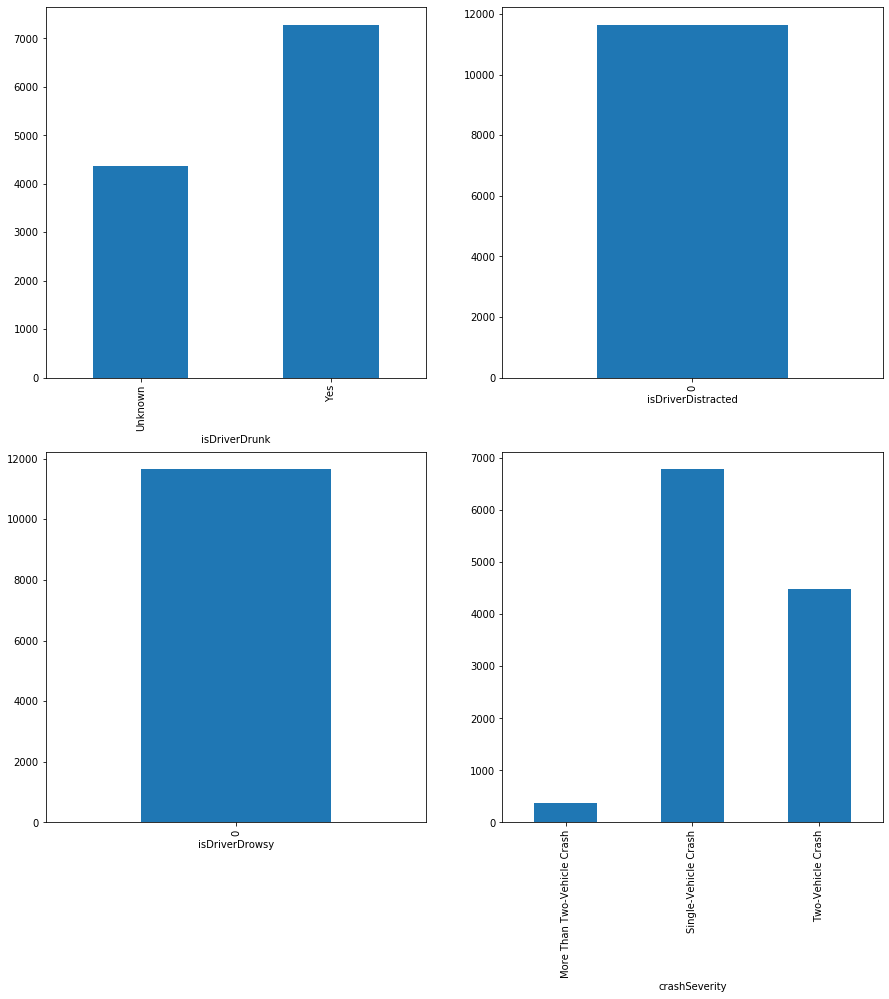

In [370]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

df_blue = df.loc[df['Cluster'] == "blue"]

df_blue.groupby(["isDriverDrunk"]).size().plot(kind="bar", ax=axes[0,0])
df_blue.groupby(["isDriverDistracted"]).size().plot(kind="bar", ax=axes[0,1])
df_blue.groupby(["isDriverDrowsy"]).size().plot(kind="bar", ax=axes[1,0])
df_blue.groupby(["crashSeverity"]).size().plot(kind="bar", ax=axes[1,1])


This clustering shows that if the driver is drunk or not known, then the probability of a single vehicle crash and two vehicle crash increases. This is why drinking and driving is so dangerous to other vehicles and pedestrians.

# Orange Cluster

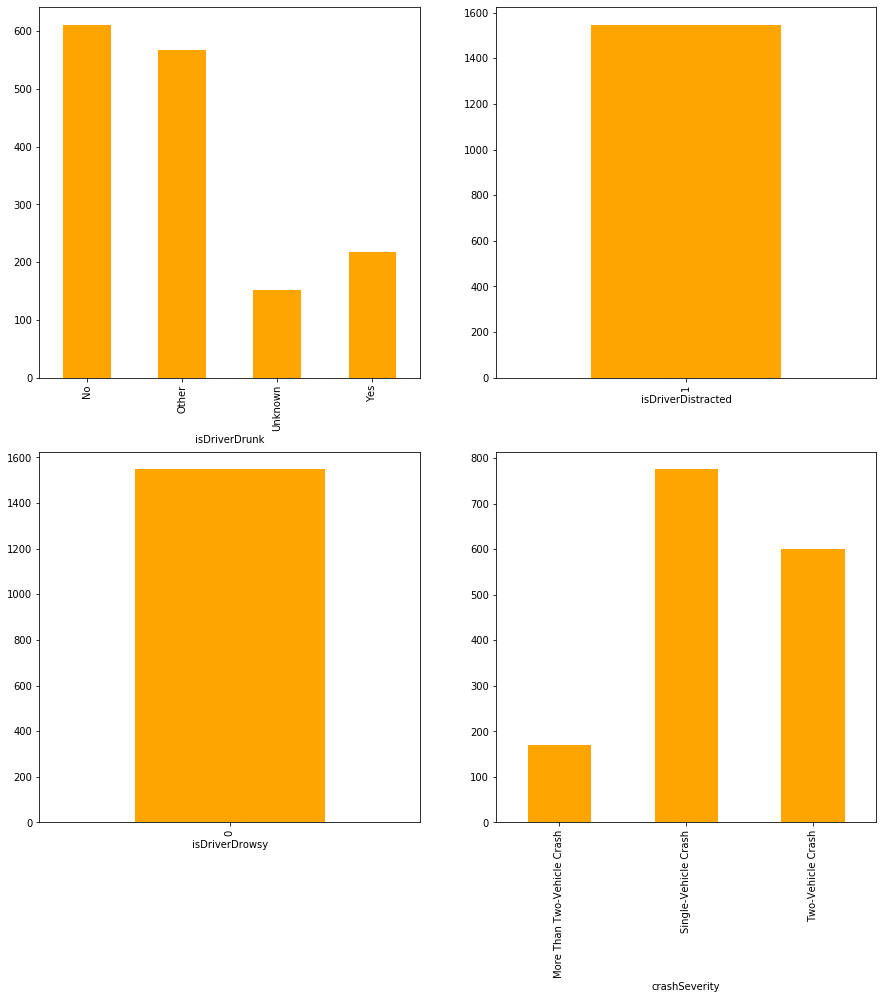

In [374]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

df_orange = df.loc[df['Cluster'] == "orange"]

df_orange.groupby(["isDriverDrunk"]).size().plot(kind="bar", ax=axes[0,0], color="orange")
df_orange.groupby(["isDriverDistracted"]).size().plot(kind="bar", ax=axes[0,1], color="orange")
df_orange.groupby(["isDriverDrowsy"]).size().plot(kind="bar", ax=axes[1,0], color="orange")
df_orange.groupby(["crashSeverity"]).size().plot(kind="bar", ax=axes[1,1], color="orange")

This clustering shows how it doesn't matter the state of the driver if the driver is distracted. A distracted driver has potential for all 3 types of accidents. This is why checking your phone while driving is dangerous. Where single vehicle crash is most likely followed by two vehicle and more than two vehicle crash.

# Green Cluster

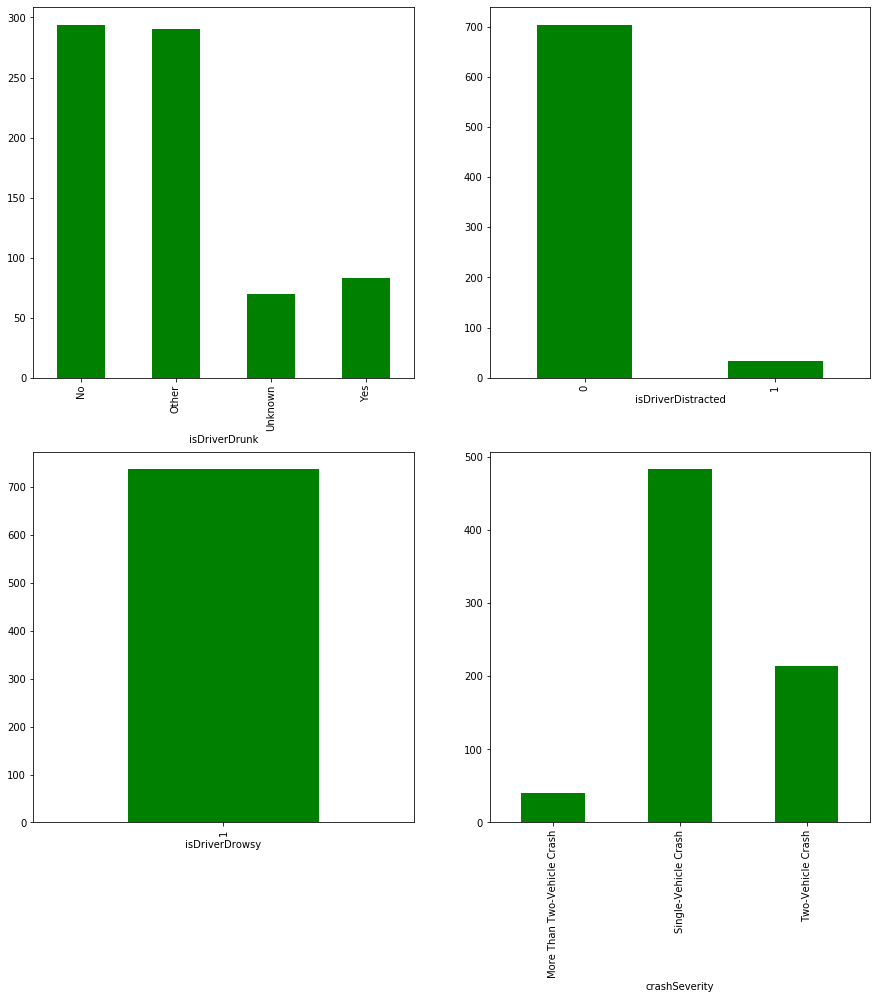

In [375]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

df_green = df.loc[df['Cluster'] == "green"]

df_green.groupby(["isDriverDrunk"]).size().plot(kind="bar", ax=axes[0,0], color="green")
df_green.groupby(["isDriverDistracted"]).size().plot(kind="bar", ax=axes[0,1], color="green")
df_green.groupby(["isDriverDrowsy"]).size().plot(kind="bar", ax=axes[1,0], color="green")
df_green.groupby(["crashSeverity"]).size().plot(kind="bar", ax=axes[1,1], color="green")

The green cluster shows the dangers of driving while drowsy. As before, the driver under any or no influence has potential to get into any of the 3 possible accidents. Again, single vehicle crash is most likely followed by two vehicle crash followed by more than two vehicle. 

## Conclusion

Looking all 5 clusters together, we notice that the blue cluster captures the most accidents. Which is then followed by the black cluster, red cluster, orange cluster and green cluster. 

The Blue and Black clusters show that the vast majority of the accidents are the results of the driver being under the influence of an unknown substance. These two clusters show that all 3 severities are possible, but the two vehicle car crash is the most likely. Which why driving under any influence is so dangerous to others.

The Red cluster captures next most number of accidents and shows that drivers that are drunk without being drowsy or distracted can cause all 3 severity crashes but single vehicle crash is the mostly likely.

The Orange cluster captures the next most number of accidents as a result of distracted driving. In this case all 3 severities of crashes are possible.

The Green cluster captures least number of accidents as a result of drowsy driving. Again, in this case all 3 severities of crashes are possible.